In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Group' 
topn = 3
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')


# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

# Define the function to predict scores and categories
def predict_text(text, tokenizer, model):
    # Ensure the input text is a string and check if it is blank
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0] 
    
    # Get the probabilities
    probs = tf.nn.softmax(output_array)
    
    # Get the top 10 predicted classes and their confidence scores
    top_10_indices = tf.argsort(probs, direction='DESCENDING')[:topn].numpy()
    return tuple(int(idx) for idx in top_10_indices)

    # top_10_probs = tf.gather(probs, top_10_indices).numpy()
    # top_10_predictions = [(int(idx), float(prob)) for idx, prob in zip(top_10_indices, top_10_probs)]
    
    # return top_10_predictions

def apply_model_to_column(df, input_col, output_col):
   
    def map_values(value_list):
        # Prepare the merged DataFrame
        lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
        lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
        merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')
        
        # Create a mapping dictionary from the reference table
        mapping_dict = dict(zip(merged_df['encoded_cat'], merged_df[lvl_train]))
        
        return [mapping_dict.get(item, item) for item in value_list]
    
    def predict_and_map(text):
        predictions = predict_text(text, tokenizer, model)
        return map_values(predictions)
    
    # Apply the predict_and_map function to the specified column and store results in a new column
    df[output_col] = df[input_col].apply(predict_and_map)
    return df


import pandas as pd
list_df_filepath = r"dataSources\ScrapedOutputFiles\(Roy) List of 90 Coy and SSIC.csv"
list_df = pd.read_csv(list_df_filepath, dtype = str)

# Create new columns
list_df['Division'] = list_df['ssic_code'].str[:2]
list_df['Group'] = list_df['ssic_code'].str[:3]
list_df['Class'] = list_df['ssic_code'].str[:4]
list_df['Sub-class'] = list_df['ssic_code']

list_df['Division2'] = list_df['ssic_code2'].str[:2]
list_df['Group2'] = list_df['ssic_code2'].str[:3]
list_df['Class2'] = list_df['ssic_code2'].str[:4]
list_df['Sub-class2'] = list_df['ssic_code2']

list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
list_df = list_df.rename(columns={'Section': 'Section'})
list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division2', right_on='Section, 2 digit code', how='left', suffixes=('', '2'))
list_df = list_df.rename(columns={'Section2': 'Section2'})

# Validation Data
# vdf_filepath = r"dataSources\ScrapedOutputFiles\(Roy) data validation.xlsx"
vdf_filepath = r"LLM_Test\Summarised_output_for_model.xlsx"
vdf = pd.read_excel(vdf_filepath, dtype = str)

vdf = vdf.merge(list_df[['UEN', 'ssic_code', 'ssic_code2', 'Section', 'Division', 'Group', 'Class', 'Sub-class', 'Section2', 'Division2', 'Group2', 'Class2', 'Sub-class2']], left_on='UEN Number', right_on='UEN', how='left')

# # Replace empty strings with NaN
# vdf = vdf.replace('', pd.NA)
# # Drop rows with any NaN values
# vdf = vdf.dropna()

pd.set_option('display.max_columns', None)  # None means no limit

# Summarized_Description_azma_bart / Azma_bart_tfidf
# Summarized_Description_facebook_bart / FB_bart_tfidf
# Summarized_Description_philschmid_bart / Philschmid_bart_tfidf

vdf = apply_model_to_column(vdf, 'Summarized_Description_azma_bart', 'p_sd_azma_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_facebook_bart', 'p_sd_fb_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_philschmid_bart', 'p_sd_philschmid_bart')
vdf = apply_model_to_column(vdf, 'Azma_bart_tfidf', 'p_azma_bart_tfidf')
vdf = apply_model_to_column(vdf, 'FB_bart_tfidf', 'p_fb_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Philschmid_bart_tfidf', 'p_philschmid_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Q&A model Output', 'p_QA')

########################################################################## Define functions to check conditions
# Create a dictionary from the reference DataFrame for mapping
ref_dict = pd.Series(ssic_1['Section'].values, index=ssic_1['Section, 2 digit code']).to_dict()

def check_section(row, ref_dict, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
    # Check if the list is empty or null
    if not predictions:
        return None
    mapped_predictions = [ref_dict.get(str(pred)[:2]) for pred in row[prediction_col_name] if str(pred)[:2] in ref_dict]
    if row['Section'] in mapped_predictions or row['Section2'] in mapped_predictions:
        return 'Y'
    else:
        return 'N'

def check_division(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if the first 2 characters of any item in predictions match either Group or Group2
    return 'Y' if any(item[:2] == row['Division'] or item[:2] == row['Division2'] for item in row[prediction_col_name]) else 'N'

def check_group(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:3] == row['Group'] or item[:3] == row['Group2'] for item in row[prediction_col_name]) else 'N'

def check_class(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:4] == row['Class'] or item[:4] == row['Class2'] for item in row[prediction_col_name]) else 'N'

def check_subclass(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:5] == row['Sub-class'] or item[:5] == row['Sub-class2'] for item in row[prediction_col_name]) else 'N'

# list_columns = ['p_azma_bart_tfidf']
list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']


# Apply the functions to create new columns
for p_column_to_check in list_columns:
    vdf[p_column_to_check + '_Section_check'] = vdf.apply(lambda row: check_section(row, ref_dict, p_column_to_check), axis=1)
    vdf[p_column_to_check + '_Division_check'] = vdf.apply(check_division, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Group_check'] = vdf.apply(check_group, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Class_check'] = vdf.apply(check_class, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Subclass_check'] = vdf.apply(check_subclass, prediction_col_name=p_column_to_check, axis=1)

# vdf[pd.isnull(vdf['Azma_bart_tfidf'])]


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_304

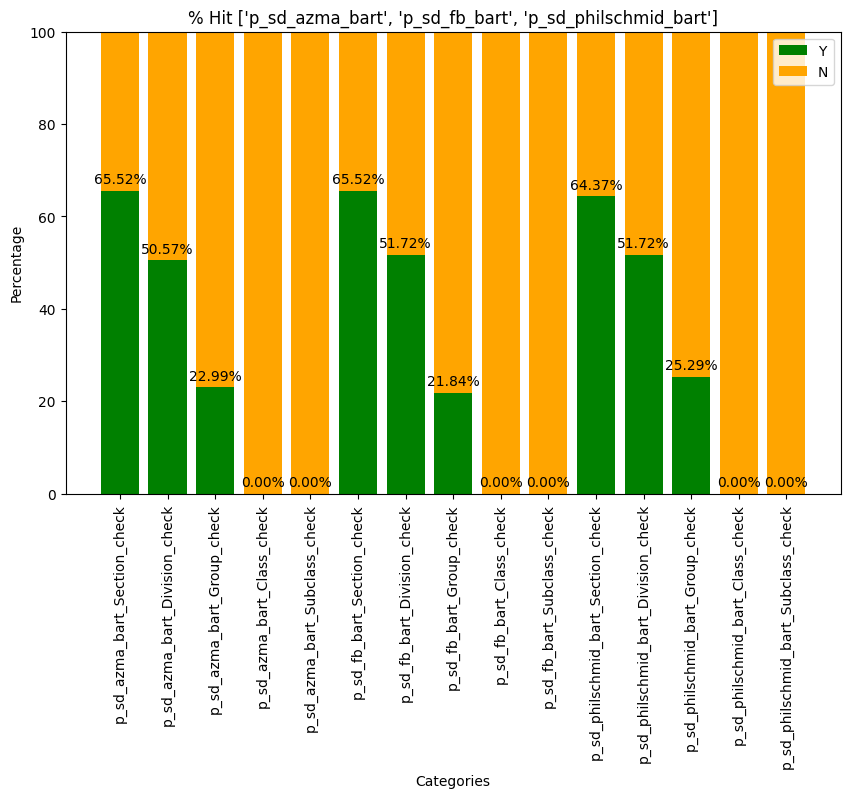

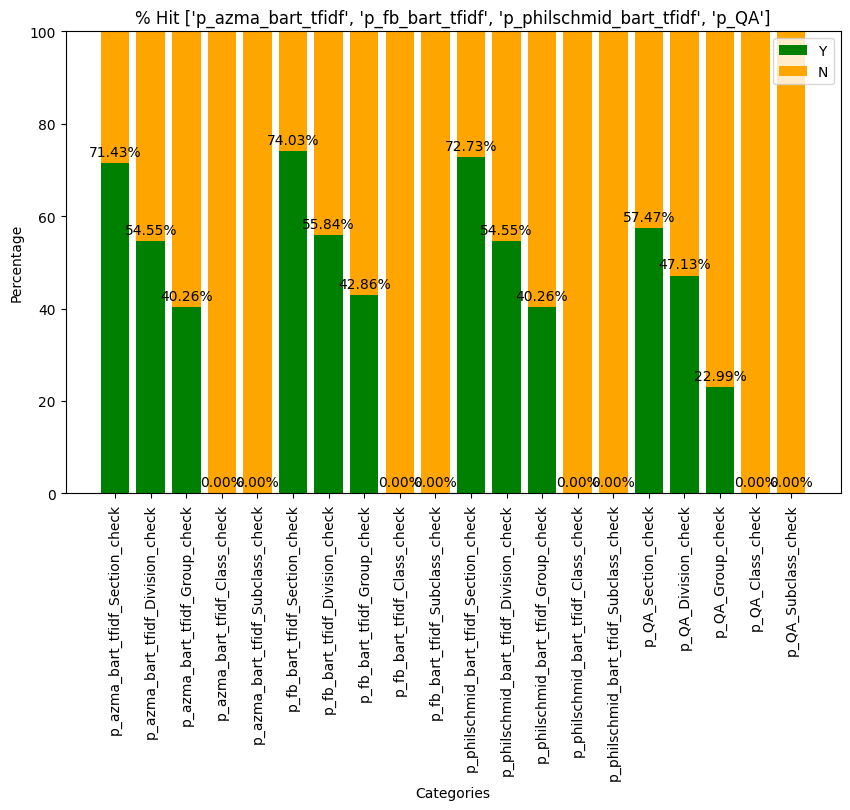

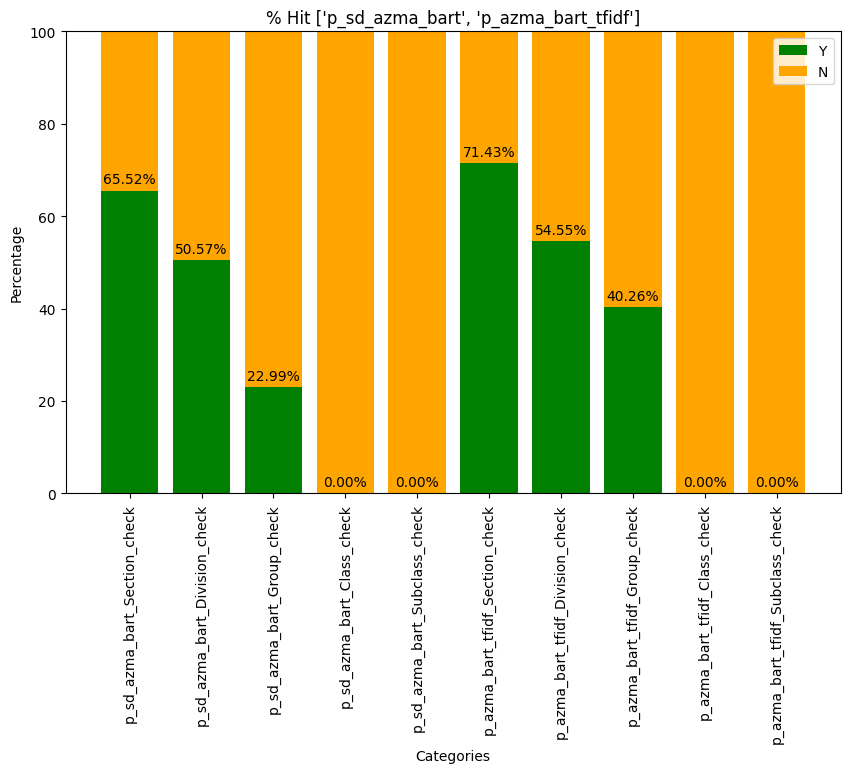

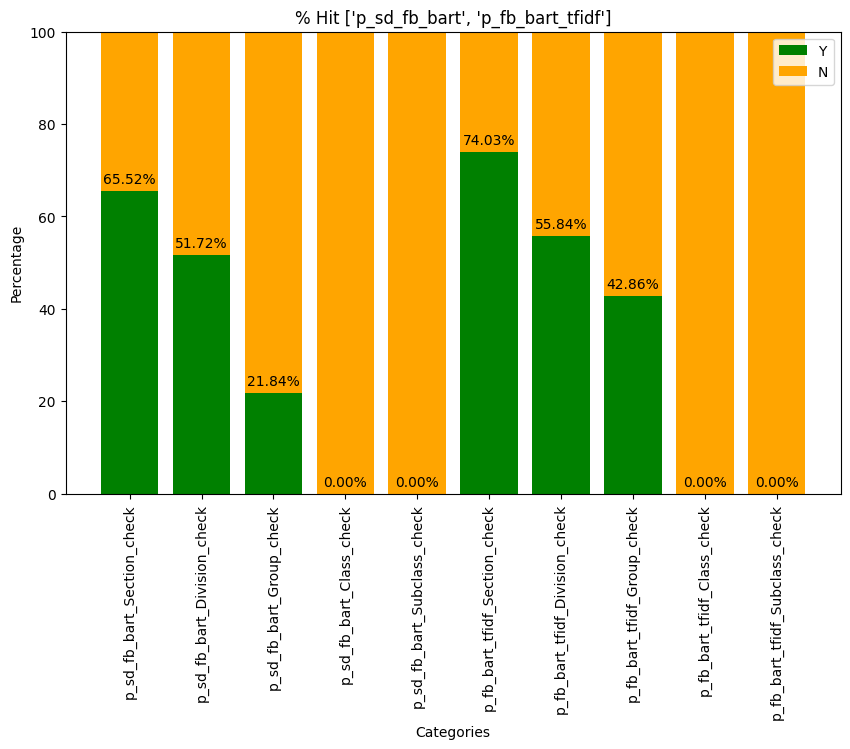

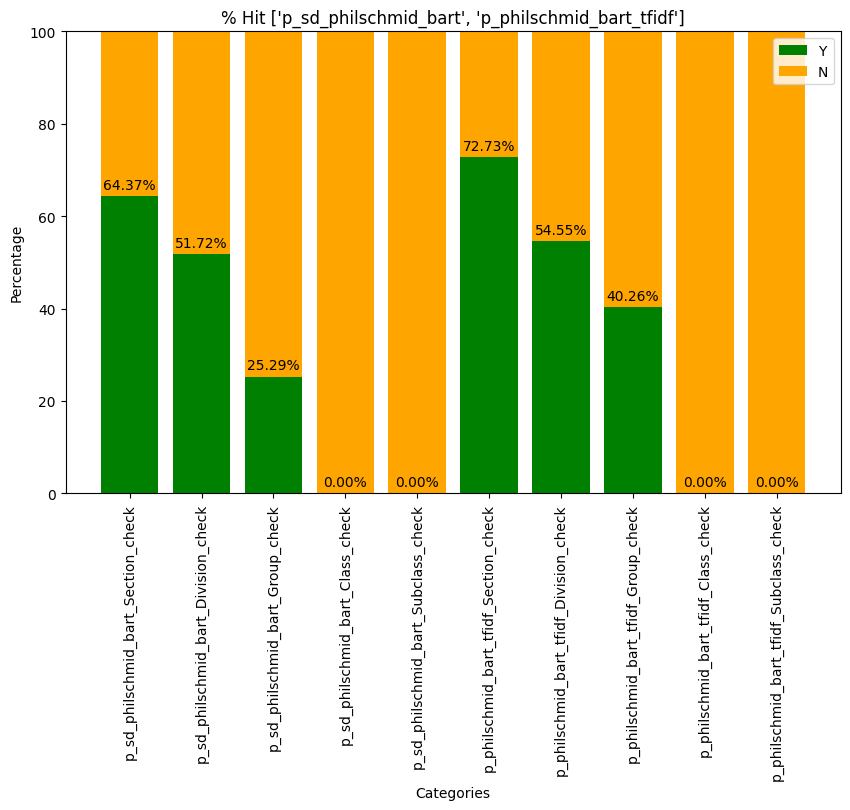

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# prefixes = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 
#             'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
]

for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Check if 'Y' and 'N' columns exist in percentages_df
    if 'Y' in percentages_df.columns and 'N' in percentages_df.columns:
        bars1 = ax.bar(percentages_df.index, percentages_df['Y'], color='green', label='Y')
        bars2 = ax.bar(percentages_df.index, percentages_df['N'], bottom=percentages_df['Y'], color='orange', label='N')

        # Adding data labels
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Customizing the plot
        ax.set_title(f'% Hit {prefix_set}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)
        ax.legend()

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Show plot
        plt.show()
    else:
        print(f"'Y' and/or 'N' columns not found for prefix set: {prefix_set}")

In [72]:
groups

{}

In [27]:
# For WY info

# Rank the predictions within each UEN group
prediction_df['Rank'] = prediction_df.groupby('entity_name').cumcount() + 1

def calculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions:
        if row['Layer'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

def calculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank' :
        return None
    
    if row['Rank'] <= top_n_predictions:
        if row['Layer2'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

###############################################################################################################################################
# Exponential Scoring
def ecalculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions and row['Layer'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1

def ecalculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank':
        return None
    
    if row['Rank'] <= top_n_predictions and row['Layer2'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1


prediction_df['score'] = prediction_df.apply(ecalculate_score, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal
prediction_df['score2'] = prediction_df.apply(ecalculate_score2, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal

# prediction_df

# Find the minimum score for each UEN
score_prediction_df = prediction_df.groupby(['entity_name']).agg({'score': 'min', 'score2': 'min'}).reset_index()

###############################################################################################################################################
# Specify Weightage for Primary and Secondary SSIC
p_weight = 1
s_weight = 0.5

score_prediction_df['t_score'] = round((score_prediction_df['score'] * p_weight + score_prediction_df['score2'].fillna(0) * s_weight) / (p_weight + (score_prediction_df['score2'].notnull() * s_weight)),2)
###############################################################################################################################################

# prediction_df = pd.merge(prediction_df, ref_df[['SSIC 2020','SSIC 2020 Title']].rename(columns={'SSIC 2020 Title': 'SSIC 2020 Title1'}), left_on='Layer', right_on='SSIC 2020', how='left')
score_prediction_df = pd.merge(score_prediction_df, grouped_prediction_df[['entity_name', 'Within Top N']], left_on='entity_name', right_on='entity_name', how='left')

###############################################################################################################################################
# Calculate the number of rows to select (top 10%)
n = 0.5  # 10% (you can adjust this percentage as needed)
top_n_rows = int(len(score_prediction_df) * n)

score_prediction_df.sort_values(by = 't_score', ascending = False).reset_index(drop=True).nlargest(top_n_rows, 't_score') # Toggle method nsmallest and nlargest


,entity_name,score,score2,t_score,Within Top N
0,MEGACHEM LIMITED,1.00,1.00,1.00,N
1,CSE GLOBAL LIMITED,1.00,1.00,1.00,N
2,OSSIA INTERNATIONAL LIMITED,1.00,1.00,1.00,N
3,PSC CORPORATION LTD.,1.00,1.00,1.00,N
4,SBI OFFSHORE LIMITED,1.00,1.00,1.00,N
5,MUN SIONG ENGINEERING LIMITED,1.00,1.00,1.00,N
6,SERIAL SYSTEM LTD,1.00,1.00,1.00,N
7,META HEALTH LIMITED,1.00,1.00,1.00,NaN
8,SEROJA INVESTMENTS LIMITED,1.00,1.00,1.00,NaN
9,JACKSPEED CORPORATION LIMITED,1.00,1.00,1.00,N


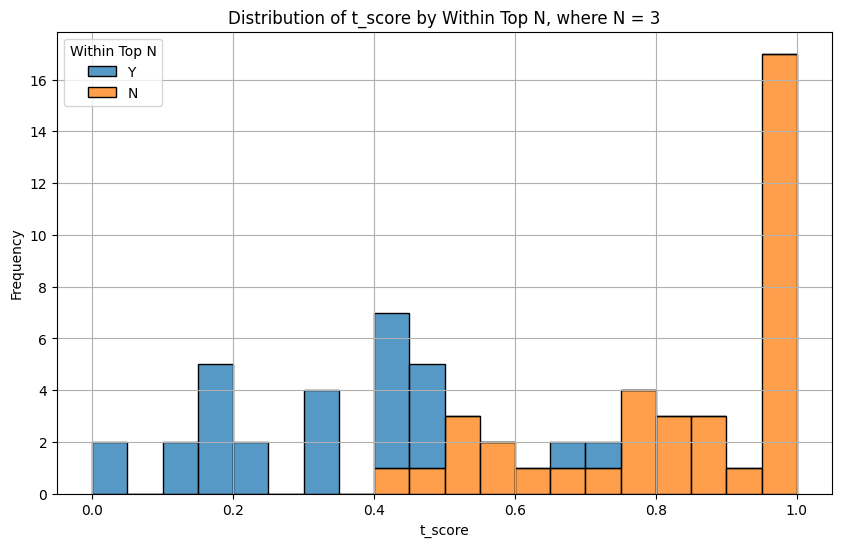

% in Top N: 32.14%
% not in Top N: 45.24%


In [28]:
# !pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of t_score colored by category
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# Histogram plot with Seaborn
sns.histplot(data=score_prediction_df, x='t_score', hue='Within Top N', multiple='stack', bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of t_score by Within Top N, where N = ' + str(N))  # Optional: Add plot title
plt.xlabel('t_score')  # Optional: Add x-axis label
plt.ylabel('Frequency')  # Optional: Add y-axis label

plt.grid(True)  # Optional: Add grid
plt.show()


# Calculate percentage of rows where column 'B' equals 'N'
count_A_equals_Y = len(score_prediction_df[score_prediction_df['Within Top N'] == 'Y'])
percentage_A_equals_Y = (count_A_equals_Y / len(score_prediction_df)) * 100
count_B_equals_N = len(score_prediction_df[score_prediction_df['Within Top N'] == 'N'])
percentage_B_equals_N = (count_B_equals_N / len(score_prediction_df)) * 100

print(f"% in Top N: {percentage_A_equals_Y:.2f}%")
print(f"% not in Top N: {percentage_B_equals_N:.2f}%")